**Importing libraries**

In [2]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torchvision import datasets, transforms


CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])


train_data = datasets.CIFAR10(root= 'data' ,train = True ,download= True , transform = train_tfms)
test_data  = datasets.CIFAR10(root= 'data' ,train = False ,download= True , transform = test_tfms)



In [3]:
#Dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)


imgs, labels = next(iter(train_loader))
print('Train batch:', imgs.shape, labels.shape)  # expect [B, 3, 32, 32], [B]
print('dtype/device:', imgs.dtype, imgs.device)
print('label range:', labels.min().item(), 'to', labels.max().item())  # expect 0..9
print('pixel stats (after norm):', imgs.mean().item(), imgs.std().item())

classes = train_data.classes
print('Classes:', classes)

/Users/admin/Documents/GitHub/ML-journey/week-03_cnns-cifar10/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train batch: torch.Size([128, 3, 32, 32]) torch.Size([128])
dtype/device: torch.float32 cpu
label range: 0 to 9
pixel stats (after norm): -0.3183462917804718 1.112312912940979
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


/Users/admin/Documents/GitHub/ML-journey/week-03_cnns-cifar10/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


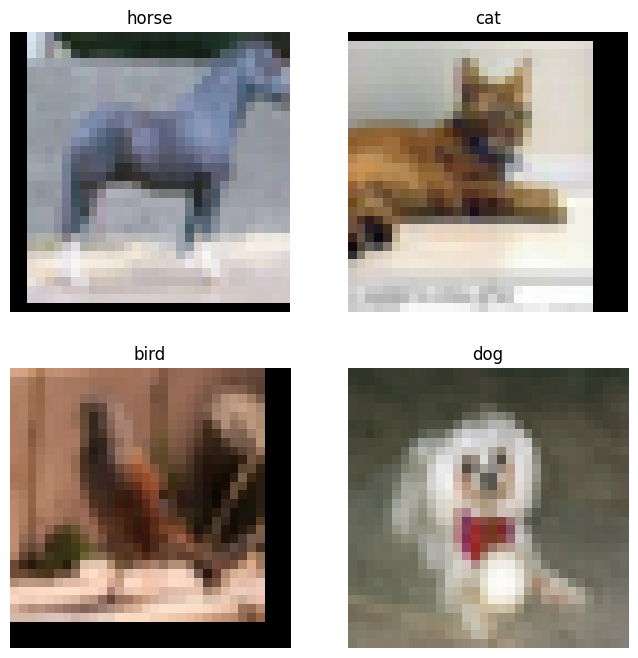

In [4]:
#Visualizing some of our CIFAR-10 DATA we're working with

import matplotlib.pyplot as plt
import numpy as np

# Helper to unnormalize and show an image
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # C,H,W → H,W,C
    img = CIFAR10_STD * img + CIFAR10_MEAN  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the first 4 images
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    imshow(images[i])
    plt.title(classes[labels[i]])
plt.show()

In [ ]:
# Defining basic reset block with skip connection

import torch.nn as nn 
import torch.nn.functional as F


def conv3x3(in_ch, out_ch, stride =1):
    return nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion =  1   #This is used by larger ResNets; Here it stays 1
    def __init__(self, in_ch, out_ch, stride = 1):
        super().__init__()        
        #main path
        self.conv1 = conv3x3(in_ch, out_ch, stride)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = conv3x3(out_ch, out_ch, 1)
        self.bn2   = nn.BatchNorm2d(out_ch)

        #Skip path (identity or 1x1 projection)
        self.downsample = None
        if stride != 1 or in_ch != out_ch:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias = False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace = True)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out, inplace = True)
        return out


In [ ]:
#stack blocks into a TinyResNet 

class TinyResNet(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride = 1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )


        # Stages: [2,2,2] basic blocks with channels [32,64,128]
        self.layer1 = self._make_layer(32,  32, blocks=2, stride=1)  # 32x32 -> 32x32
        self.layer2 = self._make_layer(32,  64, blocks=2, stride=2)  # 32x32 -> 16x16
        self.layer3 = self._make_layer(64, 128, blocks=2, stride=2)  # 16x16 -> 8x8

        self.pool = nn.AdaptiveAvgPool2d(1)      # -> (N, C, 1, 1)
        self.fc   = nn.Linear(128, num_classes)   # -> (N, 10)

         # (Optional) Kaiming init for convs
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, in_ch, out_ch, blocks, stride):
        layers = [BasicBlock(in_ch, out_ch, stride=stride)]
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_ch, out_ch, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)      # (N,32,32,32)
        x = self.layer1(x)    # (N,32,32,32)
        x = self.layer2(x)    # (N,64,16,16)
        x = self.layer3(x)    # (N,128,8,8)
        x = self.pool(x)      # (N,128,1,1)
        x = torch.flatten(x, 1)  # (N,128)
        x = self.fc(x)        # (N,10)
        return x


In [7]:
#Quick test  
from torchinfo import summary

model = TinyResNet(num_classes=10).to(device)

# Dummy forward
x = torch.randn(4, 3, 32, 32).to(device)
y = model(x)
print("Output shape:", y.shape)  # should be [4, 10]

# Parameter count
total_params = sum(p.numel() for p in model.parameters())
trainable    = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Params: {total_params:,} (trainable: {trainable:,})")

summary (model, input_size=(1,2,32,32))


#save model
torch.save(model.state_dict(), "tinyresnet_init.pt") 
   

NameError: name 'TinyResNet' is not defined